1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

     fun: 2393.204768472884
    nfev: 31
     nit: 26
 success: True
       x: -1.8511718515349764


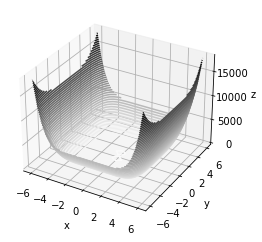

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

def f(x,y):
    return (4-2.1*x**2+(x**4)/3)*(x**2)+x*y+((4*y**2)-4)*y**2

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

solution = optimize.minimize_scalar(f, args=(5,))
print(solution)

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

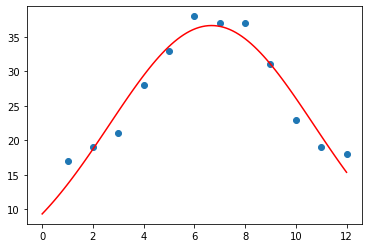

In [27]:
## max_temp = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min_temp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

months = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

n1 = len(max_temp)  ## <---
mean1 = sum(max_temp*months)/n1
sigma1 = np.sqrt(sum(max_temp*(months-mean1)**2)/n1)

n2 = len(min_temp)  ## <---
mean2 = -sum(abs(min_temp)*months)/n2
sigma2 = np.sqrt(sum(abs(min_temp)*(months-mean2)**2)/n2)

def gaus(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

popt1,pcov1 = optimize.curve_fit(gaus,months,max_temp)#,p0=[0.18,mean,sigma])  ## <--- leave out the first estimation of the parameters
xx = np.linspace( 0, 12, 100 )  ## <--- calculate against a continuous variable


plt.figure(figsize=(6, 4))
plt.scatter(months, max_temp)
plt.plot(xx,gaus(xx,*popt1),'r',label='Fit')  ## <--- plot against the contious variable
popt2,pcov2 = optimize.curve_fit(gaus,months,min_temp, p0=[0, mean2, sigma2])
plt.scatter(months, min_temp)
plt.plot(xx,gaus(xx,*popt2),'r',label='Fit')

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.